In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('sar_1.jpg')
if img is None:
    print("sar_1.jpg не найден!")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

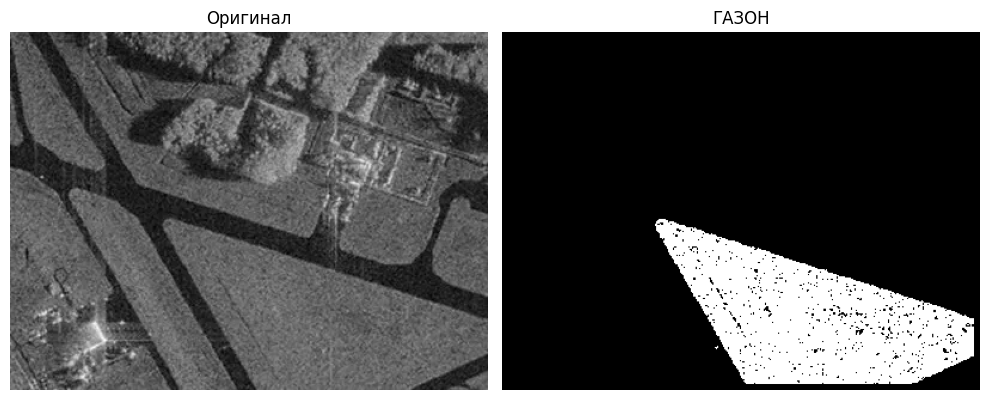

In [2]:
    def homo_average(img, mask, point, T):
        masked = img[mask > 0]
        if len(masked) == 0:
            return False
        return abs(masked.mean() - img[point]) <= T

    def region_growing(image, seed_point, homo_fun, r, T):
        h, w = image.shape
        mask = np.zeros((h, w), np.uint8)
        mask[seed_point] = 1
        count = 1
        while count > 0:
            count = 0
            local_mask = np.zeros((h, w), np.uint8)
            for i in range(r, h - r):
                for j in range(r, w - r):
                    if mask[i, j] == 0 and mask[i-r:i+r, j-r:j+r].sum() > 0:
                        if homo_fun(image, mask, (i, j), T):
                            local_mask[i, j] = 1
                            count += 1
            mask += local_mask
        return mask * 255

    seed_point = (250, 250)
    mask_gas = region_growing(gray, seed_point, homo_average, r=5, T=18)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(gray, cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask_gas, cmap='gray')
    plt.title('ГАЗОН')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

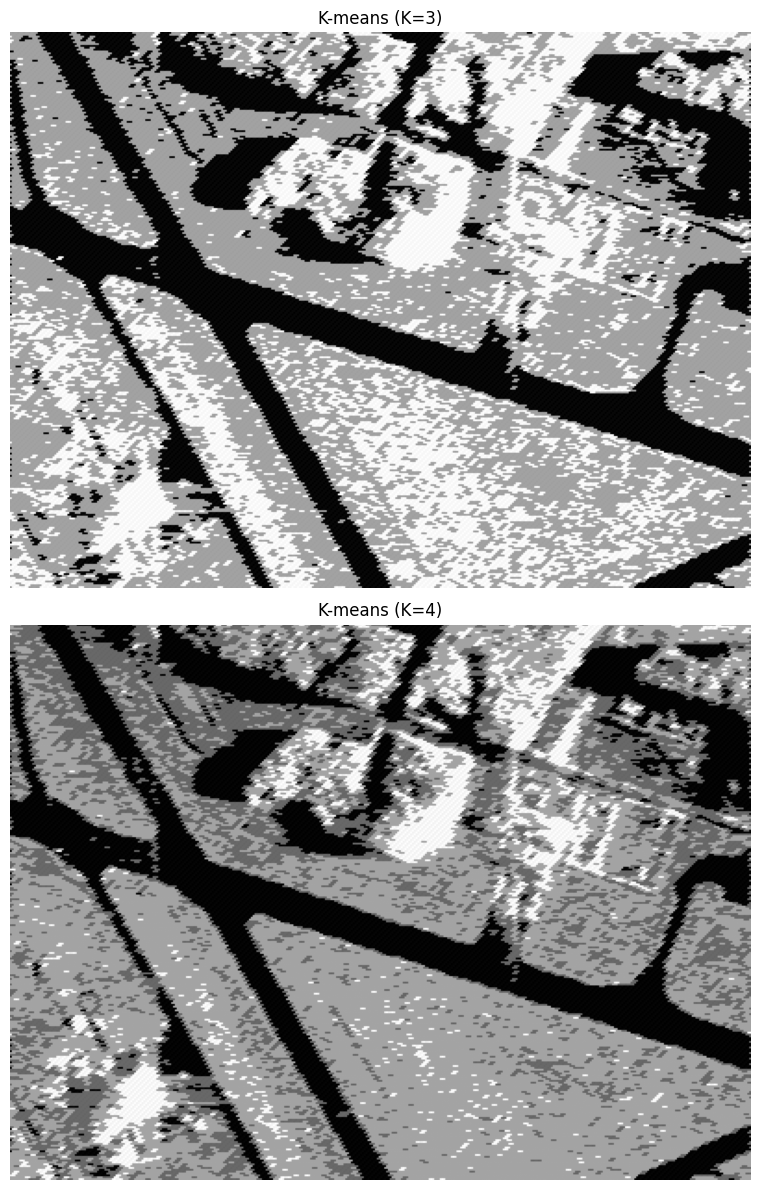

In [3]:
    z = gray.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # K=3
    _, label3, center3 = cv2.kmeans(z, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    res3 = np.uint8(center3)[label3.flatten()].reshape(gray.shape)

    # K=4
    _, label4, center4 = cv2.kmeans(z, 4, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    res4 = np.uint8(center4)[label4.flatten()].reshape(gray.shape)

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.imshow(res3, cmap='gray')
    plt.title('K-means (K=3)')
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.imshow(res4, cmap='gray')
    plt.title('K-means (K=4)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

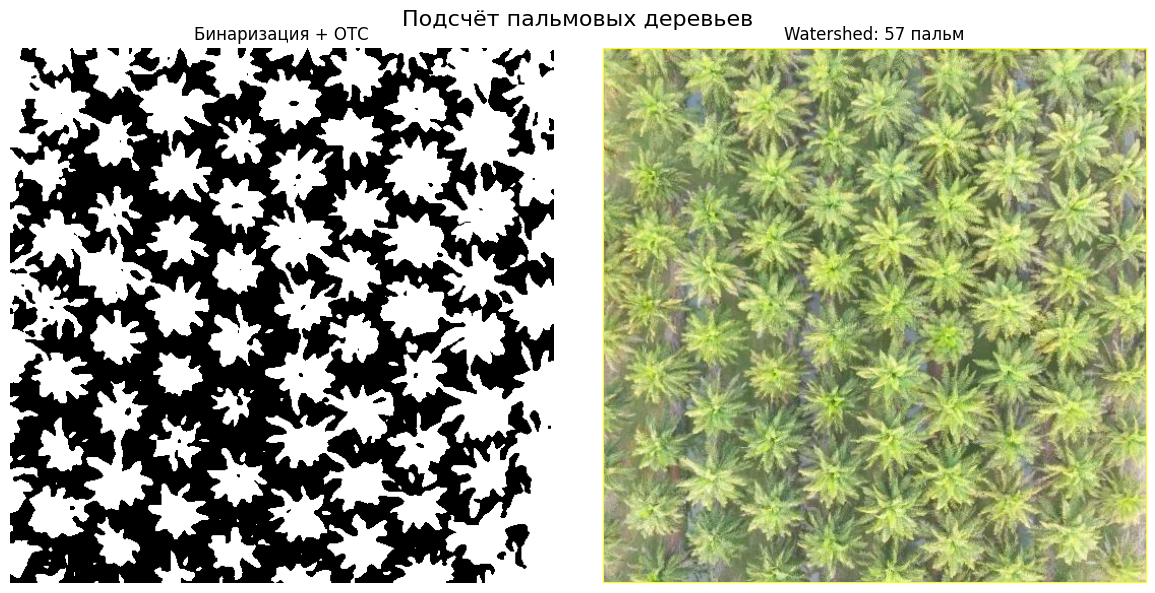

→ Подсчитано пальм: 57


In [4]:
    palm = cv2.imread('palm_1.JPG')
    if palm is None:
        print("ОШИБКА: palm_1.JPG не найден!")
    else:
        palm_rgb = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)
        palm_gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)

        # Бинаризация + ОТС
        blurred = cv2.GaussianBlur(palm_gray, (11, 11), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh = cv2.bitwise_not(thresh)

        # Distance + Watershed
        dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        _, fg = cv2.threshold(dist, 0.42 * dist.max(), 255, 0)
        fg = fg.astype(np.uint8)
        _, markers = cv2.connectedComponents(fg)
        markers = markers + 1
        markers[thresh == 0] = 0
        markers = cv2.watershed(palm_rgb, markers)

        # Подсчёт
        num_palms = len(np.unique(markers)) - 2

        # Результат
        result = palm_rgb.copy()
        result[markers == -1] = [255, 255, 0]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(thresh, cmap='gray')
        plt.title('Бинаризация + ОТС')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(result)
        plt.title(f'Watershed: {num_palms} пальм')
        plt.axis('off')
        plt.suptitle("Подсчёт пальмовых деревьев", fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"→ Подсчитано пальм: {num_palms}")